In [7]:
import pandas as pd
import re


In [27]:
# Load the datasets
file_path_newscomau = 'data_newscomau.csv'
file_path_aljazeera = 'data_aljazeera.csv'
file_path_reddit = 'reddit_data_combined.csv'

# Reading the data from each source
data_newscomau = pd.read_csv(file_path_newscomau)
data_aljazeera = pd.read_csv(file_path_aljazeera)
data_reddit = pd.read_csv(file_path_reddit)

In [28]:
data_newscomau['source'] = 'News.com.au'
data_aljazeera['source'] = 'Al Jazeera'
data_reddit['source'] = 'Reddit'

 # Selecting the relevant columns and renaming them for consistency
# Assuming that the relevant text content is in the 'body' column for news datasets and 'text' for Reddit
data_newscomau = data_newscomau[['title', 'body', 'source']].rename(columns={'body': 'text'})
data_aljazeera = data_aljazeera[['title', 'body', 'source']].rename(columns={'body': 'text'})
data_reddit = data_reddit[['title', 'text', 'date', 'type','subreddit', 'source']]  # Assuming that Reddit data has similar columns

# Combine all data into a single DataFrame
combined_data = pd.concat([data_newscomau, data_aljazeera, data_reddit], ignore_index=True)

# Convert non-string entries to strings
combined_data['text'] = combined_data['text'].astype(str)

# Initial EDA: Basic information about the data
print("Basic Information:")
print(combined_data.info())

# Show the distribution of sources
print("\nDistribution of sources:")
print(combined_data['source'].value_counts())

# Check for any duplicate entries
duplicates = combined_data.duplicated(subset=['title', 'text'], keep=False)
print(f"\nNumber of duplicate entries: {duplicates.sum()}")

# Remove duplicates if any
combined_data = combined_data[~duplicates]

print(combined_data.describe())
print(combined_data['source'].value_counts())


Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3318 entries, 0 to 3317
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      981 non-null    object
 1   text       3318 non-null   object
 2   source     3318 non-null   object
 3   date       2845 non-null   object
 4   type       2845 non-null   object
 5   subreddit  2845 non-null   object
dtypes: object(6)
memory usage: 155.7+ KB
None

Distribution of sources:
source
Reddit         2845
Al Jazeera      273
News.com.au     200
Name: count, dtype: int64

Number of duplicate entries: 151
                                                title  text  source  \
count                                             911  3167    3167   
unique                                            908  2899       3   
top     Teal MP calls out ‘distressing’ anti-Jew hate   nan  Reddit   
freq                                                2   260    2752   

       

In [29]:

# Text length analysis
combined_data['text_length'] = combined_data['text'].apply(len)
print(combined_data['text_length'].describe())

count     3167.000000
mean      1027.552573
std       2911.305390
min          1.000000
25%         55.000000
50%        154.000000
75%        649.000000
max      39306.000000
Name: text_length, dtype: float64


In [30]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', '', text)
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stop words and lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(tokens)

combined_data['processed_text'] = combined_data['text'].apply(preprocess_text)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jakel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jakel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jakel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

def adjusted_vader_sentiment(text, pos_threshold=0.1, neg_threshold=-0.1):
    scores = sia.polarity_scores(text)
    compound_score = scores['compound']
    if compound_score >= pos_threshold:
        return 'positive'
    elif compound_score <= neg_threshold:
        return 'negative'
    else:
        return 'neutral'

# Apply the adjusted function to your DataFrame
combined_data['adjusted_sentiment'] = combined_data['processed_text'].apply(adjusted_vader_sentiment)


In [37]:
from nltk.probability import FreqDist

# Tokenize words for the entire corpus
words = [word for text in combined_data['processed_text'] for word in word_tokenize(text)]

# Create frequency distribution
freq_dist = FreqDist(words)

# Print the most common words
print(freq_dist.most_common(10))


[('israel', 5000), ('hamas', 3818), ('gaza', 3767), ('said', 3581), ('palestinian', 3003), ('israeli', 2994), ('people', 2431), ('war', 1557), ('window', 1526), ('attack', 1226)]


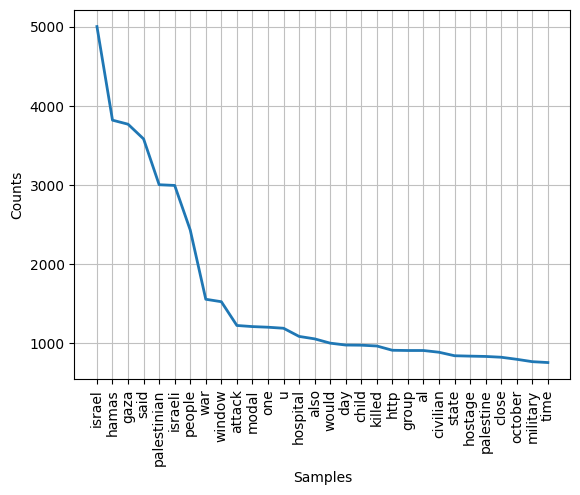

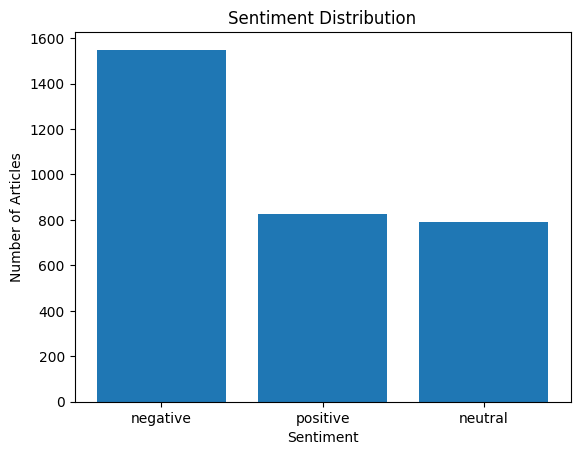

In [39]:
import matplotlib.pyplot as plt

# Plot the most common words
freq_dist.plot(30, cumulative=False)
plt.show()

# Bar chart for sentiment distribution (example)
sentiment_counts = combined_data['adjusted_sentiment'].value_counts()
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel('Sentiment')
plt.ylabel('Number of Articles')
plt.title('Sentiment Distribution')
plt.show()
